MNE : From raw data to epochs and evoked responses (ERF/ERP)
============================================================

`
Authors:
Alexandre Gramfort
Denis A. Engemann
Jona Sassenhagen
`

In [1]:
# add plot inline in the page
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

First, load the mne package:

In [2]:
import mne
mne.pick_types?

We set the log-level to 'WARNING' so the output is less verbose

In [3]:
mne.set_log_level('WARNING')

## Access raw data

Now we import the sample dataset. If you don't already have it, it will be downloaded automatically (but be patient approx. 2GB)

In [4]:
from mne.datasets import sample
# also explore other datasets, e.g. mne.datasets.XXX
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
print(raw_fname)

/Users/jona/tools/examples/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


In [5]:
print(raw_fname)

/Users/jona/tools/examples/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


Read data from file:

In [6]:
raw = mne.io.Raw(raw_fname, preload=False)

print(raw)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec)>


In [7]:
raw.ch_names[315:315 + 3]

['EEG 001', 'EEG 002', 'EEG 003']

In [8]:
# print raw.info
print(raw.proj)

False


Look at the channels in raw:

In [9]:
print(raw.ch_names[:5])

['MEG 0113', 'MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123']


In [10]:
data, times = raw[:, :10]  # fetch all channels and the first 10 time points
print(data.shape)

(376, 10)


# plotting the hard way

Read and plot a segment of raw data

In [11]:
start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
data, times = raw[:306, start:stop]
print(data.shape, times.shape, times.min(), times.max())

(306, 2252) (2252,) 99.9975041858 114.988805013


In [12]:
# picks = mne.pick_types(raw.info, meg='mag', exclude=[])
# print pick

Take some magnetometer data and plot it

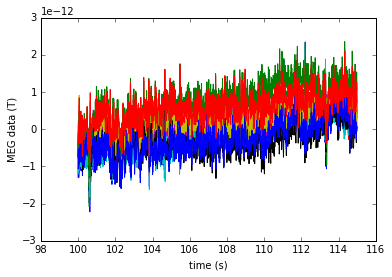

In [13]:
picks = mne.pick_types(raw.info, meg='mag', exclude=[])
data, times = raw[picks[:10], start:stop]

import matplotlib.pyplot as plt
plt.plot(times, data.T)
plt.xlabel('time (s)')
plt.ylabel('MEG data (T)')


# ... or use MNE plotters

In [14]:
%matplotlib qt4

raw.plot();

In [15]:
len(mne.pick_types(raw.info, meg=False, eeg=True, exclude='bads'))


59

In [16]:
raw.info['bads']

['MEG 2443', 'EEG 053']

Save a segment of 150s of raw data (MEG only):

In [17]:
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=True, exclude=[])
raw.save('sample_audvis_meg_raw.fif', tmin=0., tmax=150., picks=picks, overwrite=True)

Filtering:

In [18]:
raw_beta = mne.io.Raw(raw_fname, preload=True)  # reload data with preload for filtering

# keep beta band
raw_beta.filter(13.0, 30.0, method='iir')

# save the result
raw_beta.save('sample_audvis_beta_raw.fif', overwrite=True)

print(raw_beta.info)

<Info | 20 non-empty fields
    bads : 'list | MEG 2443, EEG 053
    buffer_size_sec : 'numpy.float64 | 13.3196808772
    ch_names : 'mne.io.meas_info._ChannelNameList | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : 'list | 376 items (EEG: 60, MAG: 102, STIM: 9, EOG: 1, GRAD: 204)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : 'list | 146 items
    events : 'list | 0 items
    file_id : 'dict | 4 items
    filename : 'str | /Users/jon.../sample_audvis_filt-0-40_raw.fif
    highpass : 'float | 13.0 Hz
    hpi_meas : 'list | 1 items
    hpi_results : 'list | 1 items
    lowpass : 'float | 30.0 Hz
    meas_date : 'numpy.ndarray | 2002-12-03 20:01:10
    meas_id : 'dict | 4 items
    nchan : 'int | 376
    projs : 'list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : 'float | 150.15374755859375 Hz
    acq_pars : 'NoneType
    acq_stim : 'NoneType
    ctf_head_t : 'NoneType
    desc

## Exercise :

- Filter the raw data between 1Hz and 40Hz. Observe the absence of the slow drifts.
- Plot the magnetometers and the gradiometers separately. Observe the different units.

## Define and read epochs

First extract events:

In [19]:
events = mne.find_events(raw, stim_channel='STI 014')

In [20]:
# See parameters to fine tune event detection, e.g. consecutive non-zero
# mne.find_events?

In [21]:
print(events[:5])  # events is a 2d array, (time, previous, trigger)

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [22]:
len(events[events[:, 2] == 2])

73

In [23]:
len(events)

319

Where are they coming from?

In [24]:
d, t = raw[raw.ch_names.index('STI 014'), :]
d.shape

(1, 41700)

In [25]:
raw.ch_names.index('STI 014')

312

In [26]:
raw = mne.io.Raw(raw_fname, preload=True)  # reload data with preload for filtering
raw.filter(1, 40, method='iir')

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec)>

In [27]:
plt.plot(d[0,:1000])

Events are stored as 2D numpy array where the first column is the time instant and the last one is the event number. It is therefore easy to manipulate.

In [28]:
events_new = events.copy()
events_new[events_new[:, 2] == 2, 2] = 1  # matlab like syntax
events_new[events_new[:, 2] == 4, 2] = 3
print(events_new[:5])
print(events[:5])

[[6994    0    1]
 [7086    0    3]
 [7192    0    1]
 [7304    0    3]
 [7413    0    1]]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


event 5 missing from event_id will be ignored
event 32 missing from event_id will be ignored


/Users/jona/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: event 5 missing from event_id will be ignored
/Users/jona/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: event 32 missing from event_id will be ignored


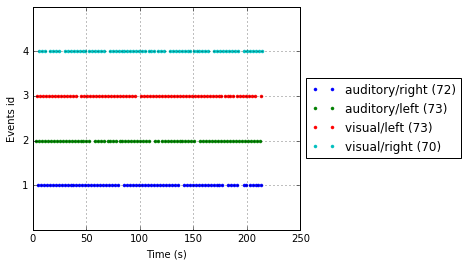

In [54]:
# event trigger and conditions
event_id = {"visual/left":3, "visual/right":4, "auditory/right":1, "auditory/left":2}
fig = mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp,
                         event_id=event_id)

Define epochs parameters:

In [55]:
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

In [56]:
event_id

{'auditory/left': 2, 'auditory/right': 1, 'visual/left': 3, 'visual/right': 4}

Mark 2 channels as bad:

In [33]:
raw.info['bads'] = ['MEG 2443', 'EEG 053']
print(raw.info['bads'])

['MEG 2443', 'EEG 053']


The variable raw.info[‘bads’] is just a python list.

Pick the good channels:

In [34]:
picks = mne.pick_types(raw.info, meg=True, eeg=True, eog=True,
                       stim=False, exclude='bads')

Alternatively one can restrict to magnetometers or gradiometers with:

In [35]:
mag_picks = mne.pick_types(raw.info, meg='mag', eog=True, exclude='bads')
grad_picks = mne.pick_types(raw.info, meg='grad', eog=True, exclude='bads')

Define the baseline period:

In [36]:
baseline = (None, 0)  # means from the first instant to t = 0

Define peak-to-peak rejection parameters for gradiometers, magnetometers and EOG:

In [37]:
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

Read epochs:

In [57]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=reject)

In [39]:
# more MNE plotters ...

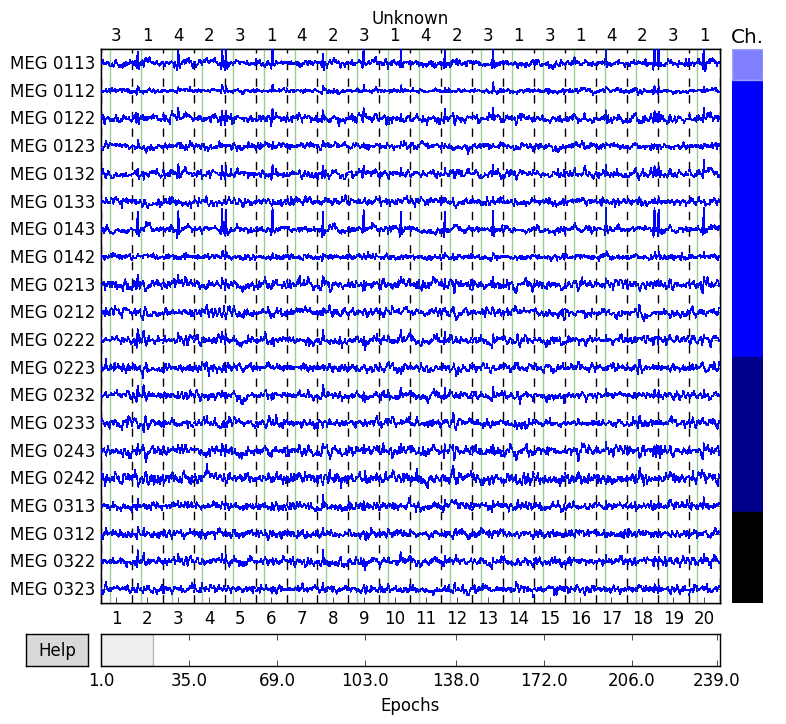

In [41]:
% matplotlib qt4

epochs.plot()

See what channels contribute to epochs rejection:

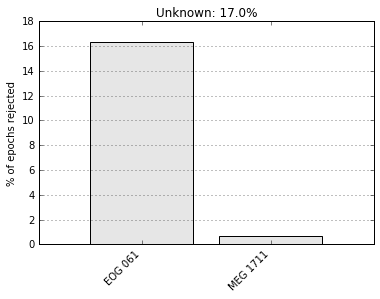

In [58]:
%matplotlib inline
epochs.drop_bad_epochs()
epochs.plot_drop_log();

In [59]:
print(epochs.drop_log[:20])

[['EOG 061'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['IGNORED'], ['EOG 061'], ['IGNORED'], [], []]


Scipy supports reading and writing of matlab files. You can save your single trials with:

In [60]:
from scipy import io
io.savemat('epochs_data.mat', dict(epochs_data=epochs.get_data()),
           oned_as='row')

or if you want to keep all the information about the data you can save your epochs in a fif file:

In [45]:
epochs.save('sample-epo.fif')

### Average the epochs to get ERF/ERP

In [61]:
evoked = epochs.average()

### Now let's visualize our ERP/ERF:

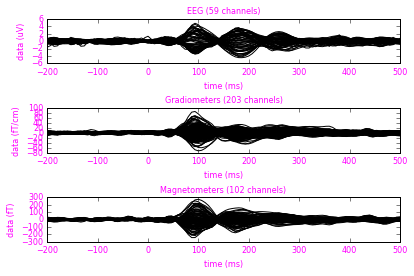

In [62]:
% matplotlib inline

fig = evoked.plot(show=False)  # butterfly plots
fig.subplots_adjust(hspace=1.0)
for text in fig.findobj(mpl.text.Text):
    text.set_fontsize(8)
    text.set_color('magenta')
fig.savefig('plot_erf.pdf');

We can also show sensor position as line color:

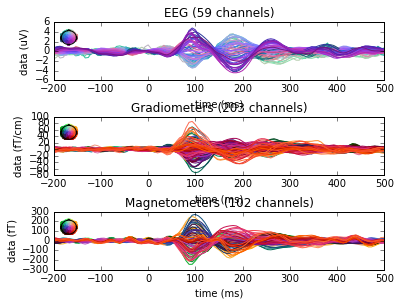

/Users/jona/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


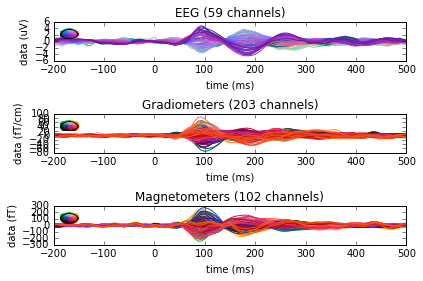

In [63]:
evoked.plot(spatial_colors=True)  # note the legend

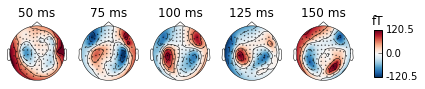

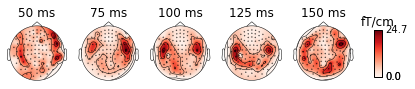

Failed to locate eeg channel positions from layout. Inferring channel positions from data.


/Users/jona/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Failed to locate eeg channel positions from layout. Inferring channel positions from data.
  app.launch_new_instance()


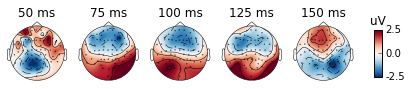

In [64]:
# topography plots
for ch_type in ('mag', 'grad', 'eeg'):
    evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type=ch_type);

Topoplot and time series can also be shown in one single plot:

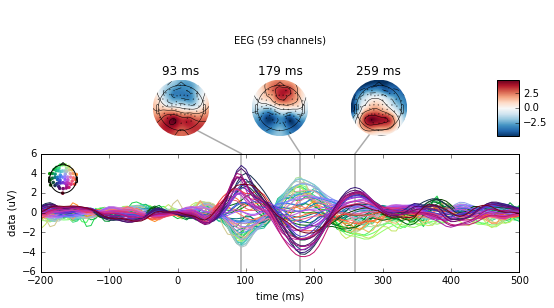

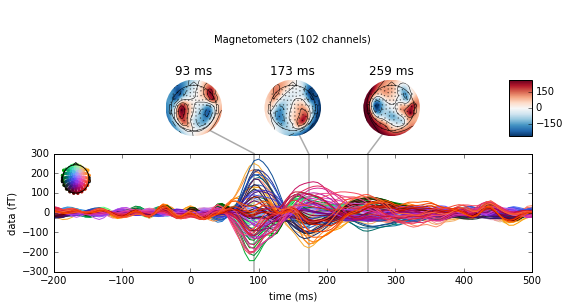

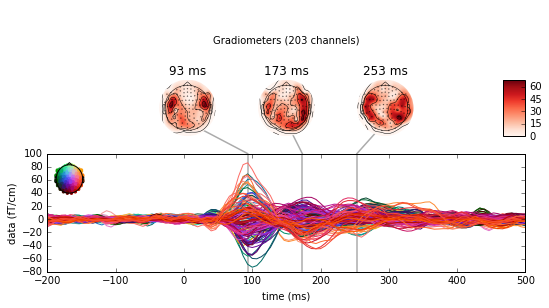

In [65]:
evoked.plot_joint()

### Get single epochs for one condition:

Syntax is `epochs[condition]`

In [66]:
epochs_data = epochs['visual/left'].get_data()
print(epochs_data.shape)

(67, 365, 106)


epochs_data is a 3D array of dimension (55 epochs, 365 channels, 106 time instants).

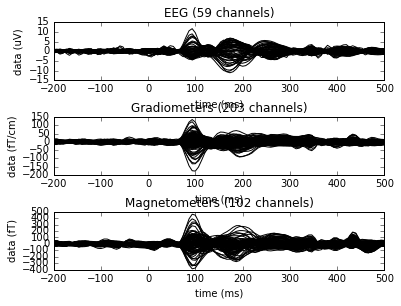

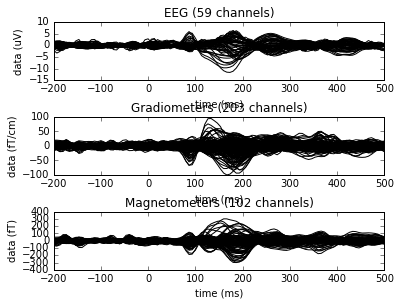

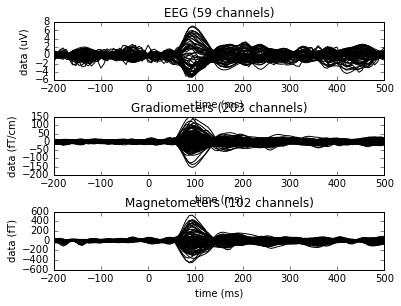

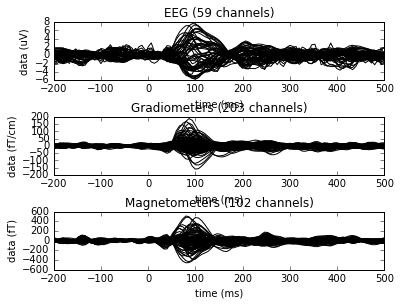

In [94]:
# Loop over conditions
for k in event_id:
    epochs[k].average().plot();

Plot selected channels and conditions only:

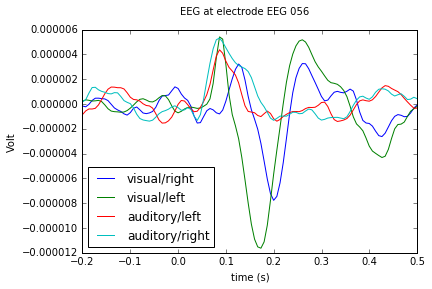

In [85]:
electrode = "EEG 056"
ax = plt.axes()
evokeds = {k:epochs[k].average() for k in event_id}
for k in evokeds:
    d = evokeds[k].pick_channels([electrode], copy=True).data.squeeze()
    plt.plot(evokeds[k].times, d, label=k)

plt.legend(loc="lower left")
plt.ylabel("Volt")
plt.xlabel("time (s)")
plt.suptitle("EEG at electrode {}".format(electrode))

In [86]:
# remember ...
event_id

{'auditory/left': 2, 'auditory/right': 1, 'visual/left': 3, 'visual/right': 4}

In event_id, "/" selects conditions in a hierarchical way, e.g. here, "auditory" vs. "visual", "left" vs. "right", and MNE can select them individually

In [87]:
print(epochs["visual"])

<Epochs  |  n_events : 123 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : (None, 0),
 'visual/left': 67, 'visual/right': 56>


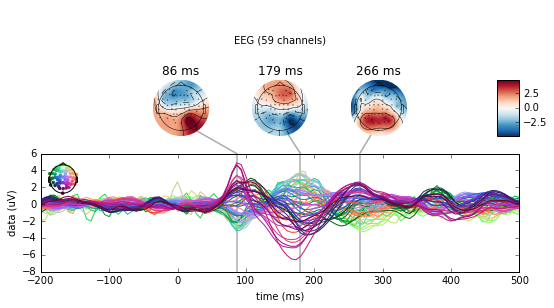

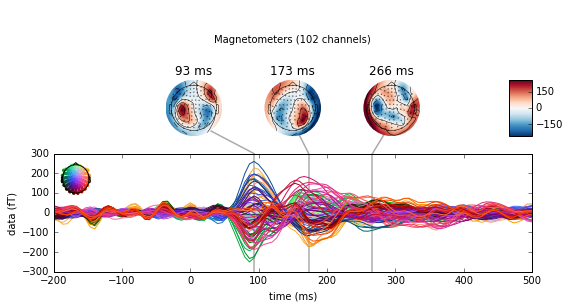

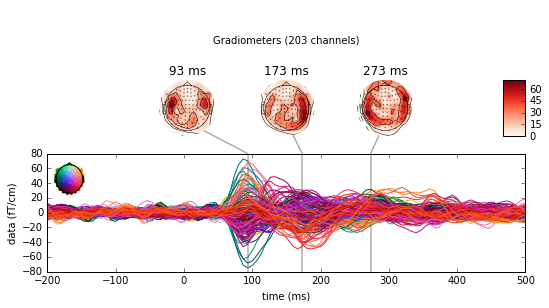

In [88]:
epochs["left"].average().plot_joint()

### Write evoked data to disk

In [ ]:
evoked.save('sample-ave.fif')

or to write multiple conditions in 1 file

In [ ]:
mne.write_evokeds('sample-ave.fif', evokeds)

## Exercise:

- Recompute epochs and evoked on highpassed data without baseline. Is it different?

### Reading evoked from disk

It is also possible to read evoked data stored in a fif file:

In [ ]:
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked1 = mne.read_evokeds(evoked_fname, condition=0, baseline=(None, 0), proj=True)

Or another one stored in the same file:

In [ ]:
evoked2 = mne.read_evokeds(evoked_fname, condition=1,
                           baseline=(None, 0), proj=True)

Or give the explicit name of the averaged condition:

In [ ]:
evoked3 = mne.read_evokeds(evoked_fname, condition='visual/left',
                           baseline=(None, 0), proj=True)

### Compute a contrast:

In [90]:
contrast = evokeds["visual/left"] - evokeds["visual/right"]
# note that this combines evokeds in a weighted way
# so if you have imbalanced trial numbers, you might not get what you want
print(contrast)
mne.combine_evoked?

<Evoked  |  comment : 'visual/left - visual/right', kind : average, time : [-0.199795, 0.499488], n_epochs : 123, n_channels x n_times : 364 x 106>


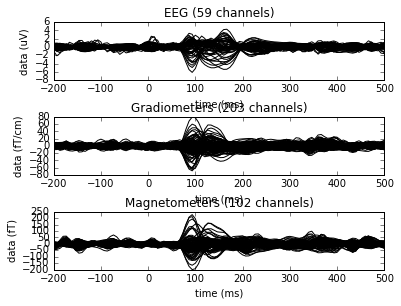

In [91]:
fig = contrast.plot()

### Save your figure as pdf

In [ ]:
# will only work on MAC
%matplotlib qt4
import numpy as np
contrast.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag')
plt.savefig('toto.pdf')
!open toto.pdf

## Exercise
- Extract Epochs restricted to magnetometers on unfiltered data (sample_audvis_raw.fif)
- Construct epochs with a whole-epoch baseline. Then, filter raw data at 1 Hz, construct epochs from that. Compare the resulting Evokeds (filter vs. baseline)
- Plot the difference between all *visual* and all *auditory* stimulus presentations

In [ ]:
raw.add_proj?